# VAE on ModelNet for scene completion

Imports and setup

In [133]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

import torch
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [2]:
sys.path.append('/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/')

from libs import dataset

Import dataset and form dataloader

In [3]:
# uses datasets and Dataset class from https://github.com/antao97/PointCloudDatasets/

# parameters :
# root : root directory, must contain file dataset_name + '_hdf5_2048
# dataset_name : modelnet10 par défaut, sinon modelnet40
# class_choice : permet de ne sélectionner qu'une classe
# split : 'train' par défaut. valeurs possibles = 'test', 'trainval', 'all', etc.
# possibilité de data augmentation également

modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', load_name=True)
modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', dataset_name='modelnet40')

In [4]:
print(f"ModelNet10 dataset has {len(modelnet10)} elements")
print(f"ModelNet40 dataset has {len(modelnet40)} elements")

ModelNet10 dataset has 3991 elements
ModelNet40 dataset has 9843 elements


In [40]:
batch_size = 4

In [41]:
mn10_loader = DataLoader(
    modelnet10,
    batch_size=batch_size,
    shuffle=True
    )

mn10_iter = iter(mn10_loader)

In [108]:
# outputs : normalized tensors of 2048 points (x,y,z)

point_set, label, name, file = next(mn10_iter)

print(f"point set = {point_set.shape}")
print(f"label = {label}")
print(f"name = {name}")
print(f"file = {file}")

point set = torch.Size([4, 2048, 3])
label = tensor([[5],
        [8],
        [5],
        [2]])
name = ('monitor', 'table', 'monitor', 'chair')
file = ('monitor/monitor_0249.ply', 'table/table_0273.ply', 'monitor/monitor_0165.ply', 'chair/chair_0397.ply')


Some visualisation

In [109]:
def display_points_list(points_list, name="inconnu"):
    """Display points list

    Args:
        points_list (torch.tensor): torch.tensor shape 2048 x 3
    """
    
    data = points_list.numpy().reshape(2048,3)
    df = pd.DataFrame(data=data, columns=['X','Y','Z'])
    fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.2, symbol_sequence=['cross'], title=f"{name}")
    
    return fig

In [ ]:
for tensor_pc in range(2):
    batch_ps, batch_labels, batch_names, _ = next(mn10_iter)
    for i in range(batch_size):
        ps = batch_ps[i]
        label = batch_labels[i]
        name = batch_names[i]
        fig = display_points_list(ps, name)
        fig.show()

Hyperparameters

In [128]:
# size of the cube
NX = 32
NY = 32
NZ = 32

### Utility functions

Class to naviagte between point clouds as list of (x,y,z) and tensor (NX,NY,NZ) of 0's and 1's

In [125]:
class PointCloud():
    """Utility class to handle point cloud
    Manages two views :
    - a list of 2048 points (x,y,z) normalized within [-1,1]^3, as out of the ModelNet datasets
    - a 3D tensor of NX x NY x NZ shape
    """
    
    def __init__(self, nx=NX, ny=NY, nz=NY, from_list=None, from_3d_tensor=None):
        self.nx = nx
        self.ny = ny
        self.nz = nz
        assert ((from_list != None) or (from_3d_tensor != None)), "need to choose between points list and 3d tensor"
        if from_list != None:
            # input is a 3D tensor shape 2048 x 3 : list of points
            self.points_list = from_list
            self.tensor_3d = None
        else:
            # input is a 3D tensor (nx x ny x nz) of 0 or 1s
            self.tensor_3d = from_3d_tensor
            self.points_list = None
        self.dx = 2 / self.nx
        self.dy = 2 / self.ny
        self.dz = 2 / self.nz
    
    def set_points_list(self):
        # assumes that self.tensor_3d exists
        # create the points_list view
        self.points_list = torch.zeros((2048,3))
        index = 0
        for i in range(self.nx):
            cx = -1 + (2*i+1)*self.dx/2
            for j in range(self.ny):
                cy = -1 + (2*j+1)*self.dy/2
                for k in range(self.nz):
                    cz = -1 + (2*k+1)*self.dy/2
                    n_points = self.tensor_3d[i,j,k]
                    if n_points >= 1:
                        for l in range(n_points):
                            # add points of ccorodinates (cx,cy,cz) to the points list
                            self.points_list[index,0] = cx
                            self.points_list[index,1] = cy
                            self.points_list[index,2] = cz
                            index += 1
    
    def set_3d_tensor(self):
        # assumes that self.points_list exists
        # create the 3d_tensor view
        self.tensor_3d = torch.zeros((self.nx, self.ny, self.nz))
        for i in range(self.points_list.shape[0]):
            # get next point in the list
            x = self.points_list[i,0]
            y = self.points_list[i,1]
            z = self.points_list[i,2]
            # get coordinates in the 3D tensor
            ix = int(np.floor((x+1)/self.dx))
            iy = int(np.floor((y+1)/self.dy))
            iz = int(np.floor((z+1)/self.dz))
            # get 1 point in the case - NB : if several points get into the case, it'll show only one !
            self.tensor_3d[ix,iy,iz] = 1
    
    def get_points_list(self):
        return self.points_list
    
    def get_3d_tensor(self):
        return self.tensor_3d
    
    def __repr__(self):
        msg = f"Point Cloud instance\n"
        msg += f"Points list view : {self.points_list}\n"
        msg += f"3D tensor view : {self.tensor_3d}\n"
        return msg

In [113]:
ps.shape

pc = PointCloud(from_list=ps)

In [114]:
pc.get_points_list()

tensor([[ 0.0276,  0.0896, -0.2823],
        [-0.3528, -0.3945,  0.8226],
        [ 0.1714,  0.3167,  0.5994],
        ...,
        [-0.0095,  0.0115,  0.6929],
        [ 0.0090,  0.2277,  0.4625],
        [ 0.0123,  0.2343, -0.4737]])

In [115]:
display_points_list(pc.get_points_list(), "quelconque")

In [116]:
# get the view as 3D tensor
pc.set_3d_tensor()

In [166]:
def display_3d_tensor(tensor_3d, name="quelconque"):
    """Display point cloud with tensor 3d (NX x NY x NZ) as input

    Args:
        tensor_3d (tensor): Torch tensor shape NX x NY x NZ
        name (str, optional): string à afficher comme titre. Defaults to "inconnu".
    """
    
    xs = []
    ys = []
    zs = []
    for i in range(NX):
        for j in range(NY):
            for k in range(NZ):
                n = tensor_3d[i,j,k]
                if n >= 1:
                    xs.append(i)
                    ys.append(j)
                    zs.append(k)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs,ys,zs,marker='.')
    ax.set_xlim(left=0, right=NX)
    ax.set_ylim(bottom=0, top=NY)
    ax.set_zlim(bottom=0, top=NZ)
    ax.set_title(name)
    
    return fig

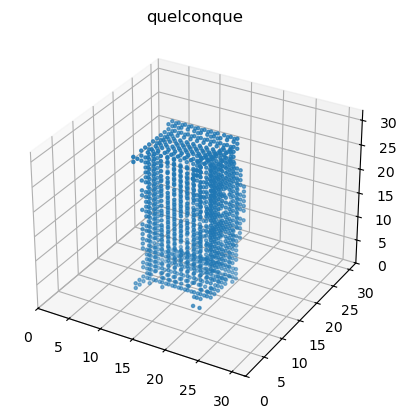

In [132]:
fig = display_3d_tensor(pc.get_3d_tensor())

### Modèle

Data

In [203]:
# datasets
modelnet10 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', load_name=True)
modelnet40 = dataset.Dataset(root='/home/benjamin.deporte/MVA/MVA_ModelNet_VAE/data/', split='all', dataset_name='modelnet40')

print(f"ModelNet10 dataset has {len(modelnet10)} elements")
print(f"ModelNet40 dataset has {len(modelnet40)} elements")

ModelNet10 dataset has 4899 elements
ModelNet40 dataset has 12311 elements


In [204]:
batch_size = 8

In [205]:
mn10_loader = DataLoader(
    modelnet10,
    batch_size=batch_size,
    shuffle=True
    )

mn40_loader = DataLoader(
    modelnet40,
    batch_size=batch_size,
    shuffle=True
)

In [206]:

NX = 64
NY = 64
NZ = 64
p = NX * NY * NZ

In [207]:
# Model paramters
latent_dim = 16

# encoder
num_hidden = 128

Graphical Model

We will use a deep latent variable model with a Gaussian prior and a Bernoulli observation model. 

A point cloud $c_i$ is a set of voxels $x_{j,k,l} \in [0,1], j \in [0, NX-1], k \in [0, NY-1], l \in [0, NZ-1]$.

This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{c}_1,...,\mathbf{c}_n) = \prod_{i=1}^n p_{\boldsymbol{\theta}}(\mathbf{c}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{c}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_{j,k,l}|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)) = \prod_{j,k,l=1}^{NX, NY, NZ} \mathcal{B} (\mathbf{x}_{ijk}|[\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)]_{i,j,k}),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow {[0,1]}^p$ is the decoder parametrised by a deep neural net. This neural net will be defined as a Pytorch model.

Prior

In [208]:
p_z = td.Independent(
    td.Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim)),
    reinterpreted_batch_ndims=1
    )

In [209]:
# draw 3 samples of dimension <latent_dim>
p_z.rsample((3,))

tensor([[-0.8829,  0.6386, -1.0459, -1.5652,  1.0878,  1.3937,  1.1493,  0.3887,
         -0.2914, -0.3202,  0.6020,  1.2559, -0.1191,  1.0933,  1.1973, -0.5347],
        [ 0.3737, -0.8414,  1.1890,  0.0715,  1.4736, -0.3938, -0.9218, -1.2797,
         -1.5266,  0.0159, -0.2156, -1.1942,  1.1602,  0.3910,  0.4765,  0.3524],
        [-0.1894, -0.2309,  1.2073,  1.0544,  0.5319, -0.3364, -0.2622,  0.4803,
         -0.0075, -1.6253, -0.2070,  0.1981,  0.3482, -0.8408, -0.4320,  0.2410]])

Encoder

In [210]:
# encoder takes as input a 3D tensor [NX,NY,NZ] of 0s and 1s

encoder = nn.Sequential(
    nn.Flatten(1,-1), # flatten into vector - NB : assumes first dim is batch_size
    nn.Linear(p, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, latent_dim*2)  # output mean and diagonal of the covariance in latent_dim
)

encoder

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=262144, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=32, bias=True)
)

In [211]:
# check dims
x = torch.randn((1,NX,NY,NZ))
print(f"x = {x.shape}")
print(f"output = {encoder(x).shape}")

x = torch.Size([1, 64, 64, 64])
output = torch.Size([1, 32])


Batch Management

In [212]:
def convert_batch_to_tensors_3d(batch_points_list):
    """Converts a tensor (batch_size x (2048 x 3)) points cloud
    in a batch (batch_size x (NX,NY,NZ))

    Args:
        batch_points_list (torch.tensor): batch_szie tensors of shape (2048 x 3)
    Returns:
        batch_size 3D_tensors of shape (NX,NY,NZ) of 0s and 1s
    """
    
    batch_dim = batch_points_list.shape[0]
    batch_tensors_3d = torch.zeros((batch_dim,NX,NY,NZ))
    for i in range(batch_dim):
        point_list = batch_points_list[i]
        pc = PointCloud(from_list = point_list)
        pc.set_3d_tensor()
        tensor_3d = pc.get_3d_tensor()
        batch_tensors_3d[i] = tensor_3d
        
    return batch_tensors_3d

In [214]:
mn10_iter = iter(mn10_loader)

for tensor_pc in range(1):
    # outputs :
    # batch_ps = batch_size x 2048 x 3 (torch.tensor)
    # batch_labels = batch_size x 1 (troche.tensor)
    batch_ps, batch_labels, _, _ = next(mn10_iter)
    print(f"batch_ps = {batch_ps.shape}")
    
    batch_tensors_3d = convert_batch_to_tensors_3d(batch_ps)
    print(f"batch converti tensors_3d = {batch_tensors_3d.shape}")

batch_ps = torch.Size([8, 2048, 3])
batch converti tensors_3d = torch.Size([8, 64, 64, 64])


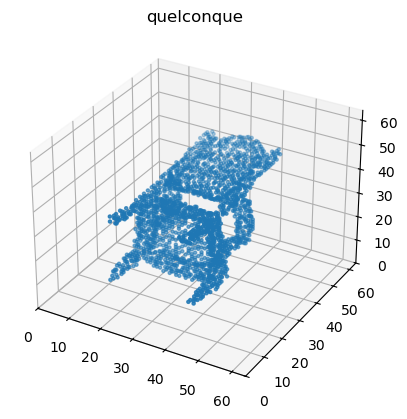

In [216]:
# check
i = 5

fig = display_3d_tensor(batch_tensors_3d[i])

In [217]:
fig = display_points_list(batch_ps[i])
fig.show()

Testing the pipeline

In [222]:
# get data
mn10_iter = iter(mn10_loader)

batch_ps, batch_label, _, _ = next(mn10_iter)
print(f"batch = {batch_ps.shape}")

batch_to_tensors = convert_batch_to_tensors_3d(batch_ps)
print(f"converted batch = {batch_to_tensors.shape}")

# encode
encoded_batch = encoder(batch_to_tensors)
print(f"encoded batch = {encoded_batch.shape}")

# parameters
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
print(f"mu = {mu_q.shape}")
print(f"sigma_q = {sigma_q.shape}")

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior = {q_zgivenx}")

batch = torch.Size([8, 2048, 3])
converted batch = torch.Size([8, 64, 64, 64])
encoded batch = torch.Size([8, 32])
mu = torch.Size([8, 16])
sigma_q = torch.Size([8, 16])
posterior = Independent(Normal(loc: torch.Size([8, 16]), scale: torch.Size([8, 16])), 1)


In [223]:
# sampling from the posterior
z_sample_reparametrized = q_zgivenx.rsample((1,))
print(f"z_posterior sample = {z_sample_reparametrized.shape}")

z_posterior sample = torch.Size([1, 8, 16])


Decoder

In [271]:
# takes z samples, outputs logits
# decoder = nn.Sequential(
#             nn.Linear(latent_dim, num_hidden),
#             nn.ReLU(),
#             nn.Linear(num_hidden, num_hidden),
#             nn.ReLU(),
#             nn.Linear(num_hidden, p)
#     )

class Decoder(nn.Module):
        def __init__(self):
                super(Decoder, self).__init__()
                self.fc1 = nn.Linear(latent_dim, num_hidden)
                self.fc2 = nn.Linear(num_hidden, num_hidden)
                self.fc3 = nn.Linear(num_hidden, p)
                
        def forward(self, inputs):
                # input is K samples x batch_size x NX x NX x NZ
                x = F.relu(self.fc1(inputs))
                x = F.relu(self.fc2(x))
                x = F.relu(self.fc3(x))
                x = x.view(x.size(0), x.size(1), NX, NY, NZ)
                return x
        
decoder = Decoder()

In [272]:
x = torch.randn(2, 16, latent_dim)
print(f"output shape = {decoder(x).shape}")

output shape = torch.Size([2, 16, 64, 64, 64])


In [267]:
# sampling
z_samples_from_prior = p_z.rsample((3,))
print(f"z_samples_from_prior = {z_samples_from_prior.shape}")
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_samples_from_prior)), 
    reinterpreted_batch_ndims = 0
)
print(f"x given z = {p_xgivenz}")
print(f"x_given z batch_shape = {p_xgivenz.batch_shape}")
print(f"x_given z event_shape = {p_xgivenz.event_shape}")
x_samples = p_xgivenz.sample((1,))
print(f"x_samples = {x_samples.shape}")

z_samples_from_prior = torch.Size([3, 16])
x given z = Independent(Bernoulli(logits: torch.Size([3, 64, 64, 64])), 0)
x_given z batch_shape = torch.Size([3, 64, 64, 64])
x_given z event_shape = torch.Size([])
x_samples = torch.Size([1, 3, 64, 64, 64])


In [268]:
# s = x_samples.shape # n_samples x batch x (NX*NY*NZ)
# x_samples = x_samples.reshape((s[0], s[1], NX, NY, NZ))
# print(f"X_samples reshaped = {x_samples.shape}")

## Computing (an estimate of) the IWAE $\mathcal{L}_K$ bound

First, we will see how to compute an unbiased estimate of the IWAE bound $\mathcal{L}_K$. It is defined as $$\mathcal{L}_K = \mathbb{E} \left[ \frac{1}{n}\sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right) \right].$$

The standard way to do so is just to sample $z_{i1}, \ldots, z_{iK} \sim q(z |x_i)$ for each data point $i$, and then do a Monte Carlo estimate of the expectation. The estimate is then simply
$$\mathcal{L}_K \approx\frac{1}{n} \sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right).$$

An efficient way to compute this is using the [logsumexp trick](https://en.wikipedia.org/wiki/LogSumExp), readily implemented in Pytorch via $\texttt{torch.logsumexp}$

In [300]:
K = 5

batch_ps, batch_label, _, _ = next(mn10_iter)
print(f"batch = {batch_ps.shape}")

batch_to_tensors = convert_batch_to_tensors_3d(batch_ps)
print(f"converted batch = {batch_to_tensors.shape}")

# encode
encoded_batch = encoder(batch_to_tensors)
print(f"encoded batch = {encoded_batch.shape}")

# parameters
mu_q = encoded_batch[:,:latent_dim]
sigma_q = nn.Softplus()(encoded_batch[:,latent_dim:])
print(f"mu = {mu_q.shape}")
print(f"sigma_q = {sigma_q.shape}")

# posterior
q_zgivenx = td.Independent(
    td.Normal(loc=mu_q, scale=sigma_q),
    reinterpreted_batch_ndims=1
)
print(f"posterior = {q_zgivenx}")

# sampling posterior samples
z_sample_reparametrized = q_zgivenx.rsample((K,))
print(f"z_samples_reparametrized = {z_sample_reparametrized.shape}")

# observation model
p_xgivenz = td.Independent(
    td.Bernoulli(logits = decoder(z_sample_reparametrized)), 
    reinterpreted_batch_ndims=3
)
print(f"observation models = {p_xgivenz}")

# computing the loss !!
log_weights = p_xgivenz.log_prob(batch_to_tensors) + p_z.log_prob(z_sample_reparametrized) - q_zgivenx.log_prob(z_sample_reparametrized) 

iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
print(iwae_bound.detach().numpy())

batch = torch.Size([8, 2048, 3])
converted batch = torch.Size([8, 64, 64, 64])
encoded batch = torch.Size([8, 32])
mu = torch.Size([8, 16])
sigma_q = torch.Size([8, 16])
posterior = Independent(Normal(loc: torch.Size([8, 16]), scale: torch.Size([8, 16])), 1)
z_samples_reparametrized = torch.Size([5, 8, 16])
observation models = Independent(Bernoulli(logits: torch.Size([5, 8, 64, 64, 64])), 3)
-185828.19


In [290]:
# checking dimensions

print(f"p_xgivenz batch shape = {p_xgivenz.batch_shape}")
print(f"p_xgivenz event shape = {p_xgivenz.event_shape}")

p_xgivenz batch shape = torch.Size([5, 8])
p_xgivenz event shape = torch.Size([64, 64, 64])


In [294]:
# p_xgivenz.log_prob(batch_to_tensors)

In [295]:
# p_z.log_prob(z_sample_reparametrized)

In [296]:
# q_zgivenx.log_prob(z_sample_reparametrized)